In [1]:
import torch
from torch import tensor
import importlib
import pandas as pd
import matplotlib.pyplot as plt

import distributions

## load helper

In [2]:
import load_helper
importlib.reload(load_helper)

fname = '5.daphne'
graph = load_helper.graph_helper(fname)
graph

[{},
 {'V': ['observe3', 'sample2', 'sample1'],
  'A': {'sample1': ['sample2'], 'sample2': ['observe3']},
  'P': {'sample1': ['sample*', ['normal', 0, 5]],
   'sample2': ['sample*', ['uniform-continuous', 0.01, ['abs', 'sample1']]],
   'observe3': ['observe*', ['normal', 0, 'sample2'], 7]},
  'Y': {'observe3': 7}},
 'sample2']

# run from source

## bbvi_algo12
* Problem 3
  * SGD not working. issues wtih normal support of bounds
  * Adam still dips ELBO low for very high batch L (300). issue var zero
  * Adam OK, still dips a bit, for T=150, L=30, lr=0.05, getting best ELBO -44 (-23 Masoud)
  * not as good: doing T=100, smaller lr=0.01, large L=1000, gets best ELBO -1676 
* Problem 4
  * T=100, L=20, Adam, lr=0.05, near to peaking, ELBO ~ -480 need to go to ~ -454. run twice as long? another 5-10 min?
  * T=250, L=20, Adam lr=0.05, ELBO -466, need to go x3-10 to get peak?, 8 min
  
* Problem 5
  * uniform can't take observes everywhere, so when use uniform-continuoys as proposal, and try to score something outside it's support (it throws an error). it can't score the log_prob, because it is impossible for it to be observed there, so there is zero probability

In [3]:
import primitives
importlib.reload(primitives)

import evaluation_based_sampling
importlib.reload(evaluation_based_sampling)

import bbvi
importlib.reload(bbvi)

from bbvi import graph_bbvi_algo12

In [ ]:
%%time
T=1000
L=20
lr=0.05
r, logW, sigma = bbvi.graph_bbvi_algo12(graph,T=T,L=L,lr=lr,
                                   do_log=False)

In [ ]:
pd.Series(logW.mean(1)).plot()
plt.xlabel('t')
plt.ylabel('ELBO')
plt.title('{} \n T={} \n L={} \n Adam, lr={}'.format(fname,T,L,lr))

In [ ]:
T=50
L=L
lr=lr
r, logW, sigma = graph_bbvi_algo12(graph,T=T,L=L,lr=lr,sigma=sigma,do_log=False)

Text(0.5, 1.0, '5.daphne \n T=200 \n L=100 \n lr=0.05')

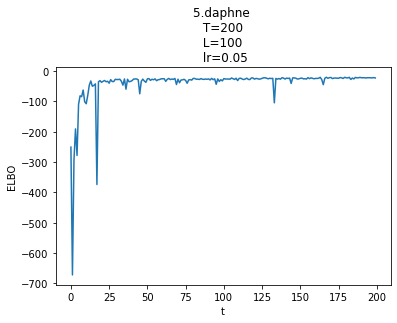

In [12]:
pd.Series(logW.mean(1)).plot()
plt.xlabel('t')
plt.ylabel('ELBO')
plt.title('{} \n T={} \n L={} \n lr={}'.format(fname,T,L,lr))

In [13]:
logW.mean(1).max()

-20.205398411750792

## problem 5

In [4]:
#torch.distributions.Gamma(tensor(2.),tensor(1.))
concentration = tensor(2.)
rate = tensor(1./0.5)
d=distributions.UniformContinuous(concentration,rate)
d.sample()

tensor(0.8494)

In [11]:
T=200
L=100
lr=0.05

r, logW, sigma = bbvi.graph_bbvi_algo12(graph,T=T,L=L,lr=lr,
                                         init_local_env={'prior_dist':{'sample2':distributions.Gamma(concentration,rate)}},
                                   #custom_proposals={'sample2':distributions.Gamma(concentration,rate)},
                                   do_log=False)

t=0, Q after step={'sample2': Gamma(concentration: 2.049999952316284, rate: 1.8545866012573242), 'sample1': Normal(loc: -0.04999999701976776, scale: 4.993239402770996)}
t=20, Q after step={'sample2': Gamma(concentration: 2.737981081008911, rate: 1.2945386171340942), 'sample1': Normal(loc: 0.4062788188457489, scale: 5.147683143615723)}
t=40, Q after step={'sample2': Gamma(concentration: 2.9851531982421875, rate: 1.0921889543533325), 'sample1': Normal(loc: 0.5101726651191711, scale: 5.190408706665039)}
t=60, Q after step={'sample2': Gamma(concentration: 3.0972938537597656, rate: 1.0041407346725464), 'sample1': Normal(loc: 0.40024858713150024, scale: 5.0716023445129395)}
t=80, Q after step={'sample2': Gamma(concentration: 3.158691883087158, rate: 0.9651890397071838), 'sample1': Normal(loc: 0.336447536945343, scale: 4.915555477142334)}
t=100, Q after step={'sample2': Gamma(concentration: 3.2066032886505127, rate: 0.9367976188659668), 'sample1': Normal(loc: 0.3002406060695648, scale: 4.7262

In [ ]:
distributions.Normal(tensor(0.),tensor(1e-38))

In [ ]:
u = evaluation_based_sampling.evaluate(['uniform-continuous',0,1])[0]
u = u.make_copy_with_grads()
u.log_prob(tensor(0.1))

In [ ]:
from distributions import UniformContinuous
u = UniformContinuous(tensor(0.),tensor(2.))
u.log_prob(tensor(2.5))


In [ ]:
u = torch.distributions.Uniform(tensor(0.),tensor(2.))
u.log_prob(tensor(2.5))

## $\lambda_{v,d} \in \mathbb{R}^{>1}$

In [ ]:
import distributions
z3 = torch.ones(3)
d = distributions.Categorical(z3)
dg = d.make_copy_with_grads()
lambda_v = d.Parameters()
len(lambda_v)

In [ ]:
from bbvi import grad_log_prob
import bbvi
importlib.reload(bbvi)

grad_log_prob(dg,tensor(2)).ndim

In [ ]:
d = distributions.Normal(tensor(0.),tensor(1.))
dg = d.make_copy_with_grads()
lambda_v = d.Parameters()
lambda_v
lambda_v[1].ndim

In [ ]:
lambda_v_d = lambda_v[0]
lambda_v_d

In [ ]:
torch.zeros_like(lambda_v_d).reshape(1,-1)

### elbo_gradients

In [ ]:
import numpy as np
G_v = np.array([[[ 0.94554961, -1.19752276,  0.47344792]],
 [[ 1.13782573, -1.44912326,  0.1195029 ]]])
# assert False, '{}'.format(G_v)
G_v.ndim

In [ ]:
logW = np.ones(2)
F_v = G_v*logW.reshape(-1,1,1)

n_D_v, D_v, L = G_v.shape
assert D_v == 1
d=0
b_v1 = np.zeros(D_v)
cov_sum_d1, var_sum_d1 = 0, 0
for j in range(n_D_v):
    G_v_1_j = G_v[:,d,j]
    F_v_1_j = F_v[:,d,j]
    cov_F_G_j = np.cov(F_v[:,d,j],G_v[:,d,j])
    cov_sum_d1 += cov_F_G_j[0,1]
    var_sum_d1 += cov_F_G_j[1,1]
b_v = cov_sum_d1 / var_sum_d1


In [ ]:
g_hat_v = (F_v - G_v*b_v1).mean(0)

In [ ]:
g_hat_v

## distributions.Normal
Barens' pseudo code

In [ ]:
import primitives
importlib.reload(primitives)

import evaluation_based_sampling
importlib.reload(evaluation_based_sampling)

from evaluation_based_sampling import evaluate

n = evaluate(['normal',0,1])[0]
n.make_copy_with_grads()

In [ ]:
torch.distributions.normal.Normal

In [ ]:
from distributions import Normal

n = Normal(tensor(0.),tensor(1.))
from primitives import distribution_types
n_torch = torch.distributions.normal.Normal(tensor(0.),tensor(1.))
isinstance(n_torch,distribution_types)



In [ ]:
isinstance(n,torch.distributions.normal.Normal)

In [ ]:
bbvi.eval_algo11

In [ ]:
isinstance(bbvi.eval_algo11(['normal',0,1],sigma={})[0],torch.distributions.normal.Normal)

## graph bbvi

In [ ]:
from graph_based_sampling import topsort
import logging

logging.basicConfig(format='%(levelname)s:%(message)s')
logger_graph = logging.getLogger('simple_example')
logger_graph.setLevel(logging.DEBUG)

def graph_bbvi(graph,sigma={},do_log=False,verteces_topsorted=None):
    """This function does ancestral sampling starting from the prior.

    graph output from `daphne graph -i sugared.daphne`
    * list of length 3
      * first entry is defn dict
        * {"string-defn-function-name":["fn", ["var_1", ..., "var_n"], e_function_body], ...}
      * second entry is graph: {V,A,P,Y}
        * "V","A","P","Y" are keys in dict
        * "V" : ["string_name_vertex_1", ..., "string_name_vertex_n"] # list of string names of vertices
        * "A" : {"string_name_vertex_1" : [..., "string_name_vertex_i", ...] # dict of arc pairs (u,v) with u a string key in the dict, and the value a list of string names of the vertices. note that the keys can be things like "uniform" and don't have to be vetex name strings
        * "P" : "string_name_vertex_i" : ["sample*", e_i] # dict. keys vertex name strings and value a rested list with a linking function in it. typically e_i is a distribution object. 
        * "Y" : observes
      * third entry is return
        * name of return rv, or constant

    """
    G = graph[1]
    verteces = G['V']
    arcs = G['A']
    if verteces_topsorted is None:
        verteces_topsorted = topsort(verteces, arcs)
    else:
        assert set(verteces) == set(verteces_topsorted)
    P = G['P']
    Y = G['Y']
    sampled_graph = {}
    local_env = {}
    
    # initialize once
    d_prior = distributions.Normal(tensor(0.),tensor(1.))
    d_prior = d_prior.make_copy_with_grads()
    sigma = {'G':{},'logW':tensor(0.),'Q':{'sample2':d_prior}}
    
    local_env, sigma = evaluate_link_function_bbvi(P,verteces_topsorted,sigma,local_env={},do_log=do_log)

    sampled_graph = local_env
    return_of_graph = graph[2] # meaning of program, but need to evaluate
    # if do_log: print('sample_from_joint local_env',local_env)
    # if do_log: print('sample_from_joint sampled_graph',sampled_graph)
    E, sigma = eval_algo11(return_of_graph,sigma, local_env = sampled_graph, do_log=do_log)
    return E, sampled_graph

graph_bbvi(graph,sigma={},do_log=True,verteces_topsorted=None)

In [ ]:
from evaluation_based_sampling import evaluate
from graph_based_sampling import score
from bbvi import grad_log_prob
import distributions

logging.basicConfig(format='%(levelname)s:%(message)s')
logger = logging.getLogger('simple_example')
logger.setLevel(logging.DEBUG)


def evaluate_link_function_bbvi(P,verteces_topsorted,sigma,local_env,do_log):
    for vertex in verteces_topsorted:
        link_function = P[vertex]
        if link_function[0] == 'sample*':
            if do_log: logger_graph.info('match case sample*: link_function {}'.format(link_function))
            assert len(link_function) == 2
            e = link_function[1]
            distribution, sigma = evaluate(e,sigma,local_env = local_env, do_log=do_log)
            
            # bbvi
            q = sigma['Q'][vertex]
            
            constant = q.sample()
            G_v = grad_log_prob(q,constant)
            sigma['G'][vertex] = G_v
            log_wv = score(distribution,constant) - score(q,constant)
            sigma['logW'] += log_wv
            if do_log: logger.info('match case sample: q {}, constant {}, G_v {}, log_wv {}, logW {}'.format(q, constant, G_v,log_wv, sigma['logW']))
            #return constant, sigma # match shape in number base case
            update_local_env = {vertex:constant}
            local_env.update(update_local_env)
        
                    
#             if do_log: logger_graph.info('match case sample*: distribution {}, sigma {}'.format(sigma, distribution))
#             E = distribution.sample() # now have concrete value. need to pass it as var to evaluate
#             update_local_env = {vertex:E}#{vertex:E, vertex+'_dist':distribution}
#             local_env.update(update_local_env)
#             local_env['prior_dist'][vertex] = distribution
        elif link_function[0] == 'observe*':
            if do_log: logger_graph.info('match case observe*: link_function {} sigma {}'.format(link_function, sigma))
            e1, e2 = link_function[1:]
            d1, sigma = evaluate(e1,sigma,local_env,do_log=do_log)
            c2, sigma = evaluate(e2,sigma,local_env,do_log=do_log)
            log_w = score(d1,c2)
            sigma  += log_w
            if do_log: logger_graph.info('match case observe*: d1 {}, c2 {}, log_w {}, sigma {}'.format(d1, c2, log_w, sigma))
        else:
            assert False

    return local_env, sigma

d_prior = distributions.Normal(tensor(0.),tensor(1.))
d_prior = d_prior.make_copy_with_grads()
evaluate_link_function_bbvi(P={'sample2': ['sample*', ['normal', 1, ['sqrt', 5]]]},
                            verteces_topsorted = ['sample2'],
                            sigma={'G':{},'logW':tensor(0.),'Q':{'sample2':d_prior}},
                            local_env={},
                            do_log=False
                           )


In [ ]:
from graph_based_sampling import topsort
import logging

logging.basicConfig(format='%(levelname)s:%(message)s')
logger_graph = logging.getLogger('simple_example')
logger_graph.setLevel(logging.DEBUG)

from graph_based_sampling import sample_from_joint

def graph_bbvi_algo12(graph,sigma={},do_log=False,verteces_topsorted=None):
    """This function does ancestral sampling starting from the prior.
    
    And then ancestral sampling from a learned proposal with bbvi

    graph output from `daphne graph -i sugared.daphne`
    * list of length 3
      * first entry is defn dict
        * {"string-defn-function-name":["fn", ["var_1", ..., "var_n"], e_function_body], ...}
      * second entry is graph: {V,A,P,Y}
        * "V","A","P","Y" are keys in dict
        * "V" : ["string_name_vertex_1", ..., "string_name_vertex_n"] # list of string names of vertices
        * "A" : {"string_name_vertex_1" : [..., "string_name_vertex_i", ...] # dict of arc pairs (u,v) with u a string key in the dict, and the value a list of string names of the vertices. note that the keys can be things like "uniform" and don't have to be vetex name strings
        * "P" : "string_name_vertex_i" : ["sample*", e_i] # dict. keys vertex name strings and value a rested list with a linking function in it. typically e_i is a distribution object. 
        * "Y" : observes
      * third entry is return
        * name of return rv, or constant

    """
    G = graph[1]
    verteces = G['V']
    arcs = G['A']
    if verteces_topsorted is None:
        verteces_topsorted = topsort(verteces, arcs)
    else:
        assert set(verteces) == set(verteces_topsorted)
    P = G['P']
    Y = G['Y']
    
    E, sampled_graph = sample_from_joint(graph,do_log=do_log)
    print('sampled_graph',sampled_graph)
    
    local_env = {}
    
    # initialize once
    d_prior = distributions.Normal(tensor(0.),tensor(1.))
    d_prior = d_prior.make_copy_with_grads()
    sigma = {'G':{},'logW':tensor(0.),'Q':{}}
    for vertex in sampled_graph['prior_dist'].keys():
        d_prior = sampled_graph['prior_dist'][vertex]
        d_prior_withgrads = d_prior.make_copy_with_grads()
        sigma['Q'][vertex] = d_prior_withgrads
    print('sigma',sigma)
    
    local_env, sigma = evaluate_link_function_algo11(P,verteces_topsorted,sigma,local_env={},do_log=do_log)

    sampled_graph = local_env
    return_of_graph = graph[2] # meaning of program, but need to evaluate
    # if do_log: print('sample_from_joint local_env',local_env)
    # if do_log: print('sample_from_joint sampled_graph',sampled_graph)
    E, sigma = eval_algo11_deterministic(return_of_graph,sigma, local_env = sampled_graph, do_log=do_log)
    return E, sampled_graph, sigma

graph_bbvi_algo12(graph,sigma={},do_log=False,verteces_topsorted=None)

In [ ]:
from evaluation_based_sampling import evaluate
from graph_based_sampling import score
from bbvi import grad_log_prob
import distributions

import bbvi
importlib.reload(bbvi)
from bbvi import eval_algo11_deterministic

def evaluate_link_function_algo11(P,verteces_topsorted,sigma,local_env,do_log):
    for vertex in verteces_topsorted:
        link_function = P[vertex]
        if link_function[0] == 'sample*':
            if do_log: logger_graph.info('match case sample*: link_function {}'.format(link_function))
            assert len(link_function) == 2
            e = link_function[1]
            # because e evaluates to distribution in linking function
            # no sample or observe in eval_algo11
            distribution, sigma = eval_algo11_deterministic(e,sigma,local_env = local_env, do_log=do_log) 
            
            # bbvi
            q = sigma['Q'][vertex]
            
            constant = q.sample()
            G_v = grad_log_prob(q,constant)
            sigma['G'][vertex] = G_v
            log_wv = score(distribution,constant) - score(q,constant)
            sigma['logW'] += log_wv
            if do_log: logger.info('match case sample: q {}, constant {}, G_v {}, log_wv {}, logW {}'.format(q, constant, G_v,log_wv, sigma['logW']))
#             #return constant, sigma # match shape in number base case
            update_local_env = {vertex:constant}
            local_env.update(update_local_env)
        
                    
#             if do_log: logger_graph.info('match case sample*: distribution {}, sigma {}'.format(sigma, distribution))
#             E = distribution.sample() # now have concrete value. need to pass it as var to evaluate
#             update_local_env = {vertex:E}#{vertex:E, vertex+'_dist':distribution}
#             local_env.update(update_local_env)
#             local_env['prior_dist'][vertex] = distribution
        elif link_function[0] == 'observe*':
            
            if do_log: logger_graph.info('match case observe*: link_function {} sigma {}'.format(link_function, sigma))
            e1, e2 = link_function[1:]
            d1, sigma = eval_algo11_deterministic(e1,sigma,local_env,do_log=do_log)
            c2, sigma = eval_algo11_deterministic(e2,sigma,local_env,do_log=do_log)
            log_w = score(d1,c2)
            sigma['logW'] += log_w
            if do_log: logger_graph.info('match case observe*: d1 {}, c2 {}, log_w {}, sigma {}'.format(d1, c2, log_w, sigma))
    
        else:
            assert False

    return local_env, sigma

d_prior = distributions.Normal(tensor(0.),tensor(2.))
d_prior = d_prior.make_copy_with_grads()
evaluate_link_function_algo11(P={'sample2': ['sample*', ['normal', 1, ['sqrt', 1]]]},
                            verteces_topsorted = ['sample2'],
                            sigma={'G':{},'logW':tensor(0.),'Q':{'sample2':d_prior}},
                            local_env={},
                            do_log=False
                           )


## elbo_gradients

In [ ]:
import bbvi
importlib.reload(bbvi)

from bbvi import elbo_gradients

## grad_log_prob

In [ ]:
import bbvi
importlib.reload(bbvi)

from bbvi import grad_log_prob

In [ ]:
loc = tensor(0.)
scale = tensor(1.)
q_nograd = Normal(loc,scale)
q = q_nograd.make_copy_with_grads()
q

In [ ]:
c = tensor(11.)

bbvi.grad_log_prob(q,c) # we need to move in the -ve direction of the gradient to make log_prob come down and maximize our log_prob

In [ ]:
lambda_v = q.Parameters()
lambda_v[0].grad, lambda_v[1].grad


In [ ]:
optimizer = torch.optim.Adam(lr=0.001)
optimizer(lambda_v)
optimizer.step()
q

In [ ]:
q

In [ ]:
optimizer.zero_grad()

In [ ]:
lambda_v[0].grad

In [ ]:
# lambda_v[0].zero_grad()

## distributions

In [ ]:
from distributions import Normal

In [ ]:
torch.distributions.normal.Normal(loc,scale).sample()

In [ ]:
loc = tensor(0.)
scale = tensor(10.)
d = Normal(loc,scale)

dg = d.make_copy_with_grads()

dg.Parameters()

optimizer = torch.optim.Adam(dg.Parameters(), lr=0.003)

data = torch.tensor([2.,2.001,2.01,1.99,2,2,2,2,2,2,2,2])



In [ ]:
for i in range(3000):
    nlp = -(dg.log_prob(data)).sum() # observe 2 from distribution
    nlp.backward()
    optimizer.step() # this is what changes dg.Parameters() 
    optimizer.zero_grad() # so doesn't accumulate
    print(dg)

In [ ]:
dg.scale

## evaluator algo 11
* This evaluator is algorithm 11 in the textbook, p. 130
* for case `sample v e`
  * it evaluates $e, \sigma, l \rightarrow d, \sigma$ recursively
  * if v is outside the domain of the proposal
    * initialize the proposal using the prior
    * store this distribution in `sigma[Q[v]]`
  * sample from the proposal, to get `c`
  * get the `grad-log-prob` of the proposal evaluated at `c`
    * store this in `sigma[G[v]]`
  * score `c` w.r.t. the distributions `d` and `sigma[Q[v]]`
    * accumulate in `sigma[logW]`
  * return `c,sigma`
* for case `observe v e1 e2`
  * eval $e1 \rightarrow d$ and $e2 \rightarrow c$
  * score `c` w.r.t. `d` and accumulate in `sigma[logW]`
  * return `c, sigma`

In [ ]:
import importlib

import evaluation_based_sampling
importlib.reload(evaluation_based_sampling)
from evaluation_based_sampling import eval_algo11

import graph_based_sampling
importlib.reload(graph_based_sampling)
from graph_based_sampling import sample_from_joint

In [ ]:
E, sampled_graph = sample_from_joint(graph,do_log=False)
sampled_graph

In [ ]:
r, sigma = eval_algo11(['sample',['normal',0,1]],sigma={'logW':tensor(0.),'Q':{},'grad':{}},local_env = sampled_graph, vertex='sample2')
r, sigma

In [ ]:
eval_algo11(['observe',['normal',0,1],-1],sigma={'logW':tensor(0.),'Q':{},'grad':{}},vertex='sample2')

In [ ]:
# import distributions
# qq = distributions.Normal(loc,scale)
# qq.sample()

## grad-log-prob
* line 9 of algo 11, p. 130
* there is no optimization happening in the evaluator, this happens in algo 12, p. 131, line 26
* we just need the gradient of the log prob of `Q[v]` (ie Q wrt v) evaluated at `c` to be stored in `sigma[G[v]]`

In [ ]:
from distributions import Normal
sigma = {}
sigma['G'] = {}
vertex='sample2'

loc = tensor(0.)
scale = tensor(1.)
q_nograd = Normal(loc,scale)
q = q_nograd.make_copy_with_grads()
c = tensor(1.)#q.sample()

def grad_log_prob(distribution_unconst_optim,c):
    log_prob = distribution_unconst_optim.log_prob(c)
    log_prob.backward()
    lambda_v = distribution_unconst_optim.Parameters()
    D_v = len(lambda_v)
    G_v = torch.zeros(D_v)
    for d in range(D_v):
        lambda_v_d = lambda_v[d]
        G_v[d] = lambda_v_d.grad
    return G_v

G_v = grad_log_prob(q,c)
sigma['G'][vertex] = G_v
c, sigma

In [ ]:
# log_prob = dg.log_prob(tensor(0.))
# log_prob
# log_prob.backward()
# G_v = dg
# dg.Parameters()[0].grad

In [ ]:
G_v

In [ ]:
log_prob.backward()

## optimizer step
* loop through vertices
* get current params in Q(v)
* do optimization (step)
* set params in Q(v) using new steps

* input
  * distribution Q(v)
  * gradient estimation g_hat

In [ ]:
lambda_v

In [ ]:
sigma

In [ ]:
g_hat['sample2']

In [ ]:
# does not work

# epsilon = 0.01
# lambda_v_p = torch.zeros(2)
# lambda_v = sigma['Q']['sample2'].Parameters()
# for idx in range(2):
#     lambda_v_p[idx] = lambda_v[idx] - epsilon*g_hat['sample2'][idx]
#     sigma['Q']['sample2'].Parameters()[idx] = lambda_v_p[idx]
# sigma['Q']['sample2'].Parameters()

In [ ]:
def optimizer_step(Q,g_hat):
    """
    no return of Q since modifies in place, and can't deep copy Q, and copy Q still accumulates
    """
    for v in g_hat.keys():
        lambda_v = Q[v].Parameters()
        optimizer = torch.optim.Adam(lambda_v, lr=1e-2)
        D_v = len(lambda_v)

        for idx in range(D_v):
            param = lambda_v[idx]
        #     param.requires_grad = True # TODO: include???

            param.grad = tensor(g_hat['sample2'][idx],dtype=torch.float32)
        optimizer.step() # moves lambda_v
        optimizer.zero_grad() # TODO: need this?      
    

Q = sigma['Q']
optimizer_step(Q,g_hat)
Q
    #param.grad = tensor(g_hat['sample2'][0])
    # param.grad = torch.from_numpy(g_hat['sample2'][0:1])
    #param.grad = torch.from_numpy(np.zeros(param.grad.shape)).type(param.grad.dtype).to(param.device)

In [ ]:
g_hat

## elbo-gradients
* input 
  * gradients for samples 1:L. 
    * These are put in sigma by the evaluator
    * try having a dictionary that maps a sample vertex string (e.g. "sample2") to a list of torch objects
  * logWs for samples 1:L. These are put in sigma by the evaluator
    * try having a dictionary that maps a sample vertex steing (e.g. "sample2") to a 0D torch array
* the body of this function, for each variable v
  * computes the cov(F,G) and var(G) over the samples, and computes b_hat
  * computes the estimate of the gradient, g_hat, with the samples summed over
* returns
  * g_hat
  

In [ ]:
G = graph[1]
P = G['P']
P

In [ ]:
# sigma={}
# sigma['grad'] = {}
# sigma['logW'] = tensor(0.)
# sigma['grad']['sample2'] = q.Parameters()

# sigma

In [ ]:
c, sigma = eval_algo11(['sample',['normal',1,1.1]],sigma={'logW':tensor(0.),'Q':{},'grad':{}},vertex='sample2')
sigma

In [ ]:
# def elbo_gradients(G,logW,union_G_keys):
#     for v in union_G_keys:
#         #F_v = []
#         G_v = []
#         g_hat = {}
#         for l in range(L):
#             G_l = G[l]
#             if v in G_l.keys():
#                 G_l_v = G_l[v].tolist()
#                 G_v.append(G_l_v)
#                 D_v = len(G_l_v)
#                 #F_v_l = G_l_v*logW[t][l]
#                 #F_v.append(F_v_l) # data specific tolist might not always work
#             else:
#                 assert False, 'zero not implemented'
#         G_v = np.array(G_v)
#         F_v = G_v*logW.reshape(-1,1)

#         # cov and var to compute b_v
#         assert G_v.ndim == 2
#         D_v = G_v.shape[1]
#         b_v = np.zeros(D_v)
#         for d in range(D_v):
#             F_v_d = F_v[:,d]
#             G_v_d = G_v[:,d]
#             cov_F_G = np.cov(F_v_d,G_v_d)
#             b_v[d] = cov_F_G[0,1]/cov_F_G[1,1]
#         g_hat_v = (F_v - G_v*b_v).sum(0)  # sum over samples
#         g_hat[v] = g_hat_v
#     return g_hat
    
# elbo_gradients(G,logW[t],union_G_keys=set(['sample2']))  
    
    

In [ ]:
def elbo_gradients(G,logW,union_G_keys):
    for v in union_G_keys:
        #F_v = []
        G_v = []
        g_hat = {}
        for l in range(L):
            G_l = G[l]
            if v in G_l.keys():
                G_l_v = G_l[v].tolist()
                G_v.append(G_l_v)
                D_v = len(G_l_v)
                #F_v_l = G_l_v*logW[t][l]
                #F_v.append(F_v_l) # data specific tolist might not always work
            else:
                assert False, 'zero not implemented'
        G_v = np.array(G_v)
        F_v = G_v*logW.reshape(-1,1)

        # cov and var to compute b_v
        assert G_v.ndim == 2
        D_v = G_v.shape[1]
        b_v = np.zeros(D_v)
        for d in range(D_v):
            F_v_d = F_v[:,d]
            G_v_d = G_v[:,d]
            cov_F_G = np.cov(F_v_d,G_v_d)
            b_v[d] = cov_F_G[0,1]/cov_F_G[1,1]
        g_hat_v = (F_v - G_v*b_v).mean(0)  # sum over samples divided by L
        g_hat[v] = g_hat_v
    return g_hat
    
elbo_gradients(G,logW[t],union_G_keys=set(['sample2']))  
    
    

In [ ]:
G[0]['sample2']

## BBVI
* input 
  * T : int time steps
  * L : int num_samples
 

In [ ]:
import importlib
import evaluation_based_sampling
importlib.reload(evaluation_based_sampling)

from evaluation_based_sampling import eval_algo11


In [ ]:
import numpy as np




def bbvi_algo12(T,L):
    r, G = [], []
    logW = np.zeros((T,L))

    E, sampled_graph = sample_from_joint(graph,do_log=False)

    sigma={'logW':tensor(0.),'Q':{},'grad':{}}
    e = ['sample',['normal',1,1.1]]

    for t in range(T):
        G = []
        r_t=[]
        union_G_t_keys = set()
        for l in range(L):
            # loop through vertex and evaluate linker functions as e
            r_t_l, sigma = eval_algo11(e,sigma=sigma,local_env = sampled_graph, vertex='sample2',do_log=False)
            logW[t,l] = sigma['logW'].item()
            G_l = (sigma['grad']).copy()
            union_G_keys.update(set(G_l.keys()))
            G.append(G_l)
            r_t.append(r_t_l)
        g_hat = elbo_gradients(G,logW[t],union_G_keys) 
        Q = sigma['Q']
        optimizer_step(Q,g_hat) # in place modification of Q

        r.append(r_t)
    return r, logW
        

In [ ]:
T=3
L=50
bbvi_algo12(T,L)[-1]

In [ ]:
sigma={'logW':tensor(0.),'Q':{},'grad':{}}
r, sigma = eval_algo11(e,sigma=sigma,local_env = sampled_graph, vertex='sample2',do_log=True)

In [ ]:
# r, sigma = eval_algo11(['sample',['normal',0,1]],sigma={'logW':tensor(0.),'Q':{},'grad':{}},local_env = sampled_graph, vertex='sample2')
# r, sigma

In [ ]:
vertex='sample2'
q = sigma['Q'][vertex]

grad_log_prob(q,tensor(0.))